In [28]:
from mistralai import Mistral
import os
import requests
import base64
import numpy as np

In [22]:
from transformers import AutoModel
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('jinaai/jina-embeddings-v2-base-en', trust_remote_code=True)
model = AutoModel.from_pretrained('jinaai/jina-embeddings-v2-base-en', trust_remote_code=True)

/home/singh4u1/citywindsor/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- modeling_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [ ]:
mistral_api_key = os.getenv("MISTRAL_API_KEY")
mistral_ocr_url = "https://api.mistral.ai/v1/ocr"
ocr_model = "mistral-ocr-latest"
# client = Mistral(api_key=mistral_api_key)

In [3]:
def encode_pdf(pdf_path):
    """Encode the pdf to base64."""
    try:
        with open(pdf_path, "rb") as pdf_file:
            return base64.b64encode(pdf_file.read()).decode('utf-8')
    except FileNotFoundError:
        print(f"Error: The file {pdf_path} was not found.")
        return None
    except Exception as e:  # Added general exception handling
        print(f"Error: {e}")
        return None


In [10]:
pdf_path = "./pdfs/8607-8649-8675-8699-McHugh-Street/Application Form Plan of Subdivision or Condominium.pdf"
if not os.path.exists(pdf_path):
    raise FileNotFoundError(f"File not found: {pdf_path}")

# encode the pdf to base64
base64_pdf = encode_pdf(pdf_path)

print("sending request")
# make a post request to the mistral url
mistral_response = requests.post(
    mistral_ocr_url,
    headers={
        "Authorization": f"Bearer {mistral_api_key}",
        "Content-Type": "application/json"
    },
    json={
        "model": ocr_model,
        "document": {
            "type": "document_url",
            "document_url": f"data:application/pdf;base64,{base64_pdf}"
        }
    }
)
print("request sent")

sending request
request sent


In [207]:
def create_chunks(data, chunk_size = 512, overlap=256):
    chunks = []
    for page in data["pages"]:
        # split the markdown into chunks
        text = page["markdown"]
        # split the text into chunks of size chunk_size
        for i in range(0, len(text), chunk_size):
            chunk = text[i:i+chunk_size]
            chunks.append(chunk)
    return chunks

def create_smart_chunks(data, chunk_size=512, overlap=256):
    import re
    chunks = []
    page_numbers = {}
    # for page in data["pages"]:
    for page_number, page in enumerate(data["pages"]):
        text = page["markdown"]
        table_start_pattern = r"(\n\|)"
        table_end_pattern = r"(\|\n(?!\|))"
        
        # Find table starts and ends
        table_starts = [m.start() for m in re.finditer(table_start_pattern, text)]
        table_ends = [m.start() for m in re.finditer(table_end_pattern, text)]
        
        char_index = 0
        i = 0
        j = 0
        # for i in range(len(table_starts)):
        temp_chunks = []
        print(table_starts)
        while i < len(table_starts) and j < max(len(table_ends), 1):
            print("inside this loop")
            # Capture non-table text before the current table
            if table_starts[i] > char_index:
                print("capturing non-table text")
                non_table_chunk = text[char_index:table_starts[i]].strip()
                if non_table_chunk:
                    # call create_chunks on the non-table chunk
                    non_table_chunks = create_chunks({"pages": [{"index": page_number, "markdown": non_table_chunk}]}, chunk_size, overlap)
                    for chunk in non_table_chunks:
                        if chunk not in page_numbers:
                            page_numbers[chunk] = []
                        page_numbers[chunk].append(page_number+1)
                    temp_chunks.extend(non_table_chunks)
                    # char_index = table_starts[i]
                # continue
            
            # Capture the table chunk
            start = table_starts[i]
            end = table_ends[j] if j < len(table_ends) else len(text)

            char_index = end + 1
            j += 1
            i += 1
            # check if table_starts[i] is greater than table_ends[j]
            # if not skip table starts until it is
            while i < len(table_starts) and j < len(table_ends) and table_starts[i] < table_ends[j]:
                i += 1
            # add some pre-start context to the table:
            table_chunk = text[start:end+1].strip()
            if table_chunk:
                temp_chunks.append(table_chunk)
        
        # Capture any remaining non-table text after the last table
        if char_index < len(text):
            remaining_chunk = text[char_index:].strip()
            if remaining_chunk:
                # temp_chunks.append(remaining_chunk)
                # call create_chunks on the remaining chunk
                remaining_chunks = create_chunks({"pages": [{"index": page_number, "markdown": remaining_chunk}]}, chunk_size, overlap)
                for chunk in remaining_chunks:
                    if chunk not in page_numbers:
                        page_numbers[chunk] = []
                    page_numbers[chunk].append(page_number+1)
                temp_chunks.extend(remaining_chunks)
        # add page number to each chunk
        for chunk in temp_chunks:
            if chunk not in page_numbers:
                page_numbers[chunk] = []
                page_numbers[chunk].append(page_number+1)
        
        chunks.extend(temp_chunks)

    return chunks, page_numbers
chunks, page_numbers = create_smart_chunks(mistral_response.json(), chunk_size=512, overlap=256)
# chunks, page_numbers = create_smart_chunks(pdf_data, chunk_size=512, overlap=256)
# if there are any chunks that are smaller than 512 characters, move them to the previous chunk
for i in range(len(chunks)):
    if len(chunks[i]) < 512:
        # move the chunk to the previous chunk
        if i > 0:
            chunks[i-1] += "\n" + chunks[i]
            chunks[i] = ""
# remove empty chunks and page entries for removed chunks
chunks = [chunk for chunk in chunks if chunk != ""]
for chunk in chunks:
    if chunk in page_numbers:
        del page_numbers[chunk]
print([len(chunk) for chunk in chunks])

[]
[]
[]
[]
[]
[646, 710, 740, 814, 866, 914, 998, 1044, 1067, 1086, 1117, 1138, 1262, 1325, 1355, 1405, 1458, 1516, 1580, 1641, 1671, 1723, 1765, 1801]
inside this loop
capturing non-table text
inside this loop
capturing non-table text
inside this loop
capturing non-table text
[235, 289, 305, 405, 450, 521, 610, 638, 671]
inside this loop
capturing non-table text
[]
[153, 211, 269, 449, 510, 576, 631, 697, 748, 785, 828, 864, 900, 949, 993, 1024, 1065]
inside this loop
capturing non-table text
[]
[]
[377, 427, 457, 532, 574, 649, 720, 819, 943, 1038, 1068, 1110, 1185, 1256, 1361, 1511, 1553, 1583, 1671, 1713, 1788, 1859, 1948]
inside this loop
capturing non-table text
inside this loop
capturing non-table text
[]
[]
[]
[]
[]
[]
[574, 613, 636, 726, 776, 826, 886, 916, 933, 944]
inside this loop
capturing non-table text
[512, 512, 512, 512, 512, 512, 512, 598, 512, 512, 512, 512, 512, 962, 512, 512, 512, 512, 512, 512, 512, 512, 1013, 512, 512, 845, 512, 512, 532, 646, 302, 312, 423, 29

In [175]:
# create a collective text from the chunks
collective_text = ""
for chunk in chunks:
    collective_text += chunk + "[SEP]"
# get span_annotations for chunks

def chunk_by_sentences(input_text: str, tokenizer: callable):
    """
    Split the input text into sentences using the tokenizer
    :param input_text: The text snippet to split into sentences
    :param tokenizer: The tokenizer to use
    :return: A tuple containing the list of text chunks and their corresponding token spans
    """
    inputs = tokenizer(input_text, return_tensors='pt', return_offsets_mapping=True)
    punctuation_mark_id = tokenizer.convert_tokens_to_ids('.')
    sep_id = tokenizer.convert_tokens_to_ids('[SEP]')
    token_offsets = inputs['offset_mapping'][0]
    token_ids = inputs['input_ids'][0]
    chunk_positions = [
        (i, int(start + 1))
        for i, (token_id, (start, end)) in enumerate(zip(token_ids, token_offsets))
        if token_id == punctuation_mark_id
        and (
            token_offsets[i + 1][0] - token_offsets[i][1] > 0
            or token_ids[i + 1] == sep_id
        )
    ]
    chunks = [
        input_text[x[1] : y[1]]
        for x, y in zip([(1, 0)] + chunk_positions[:-1], chunk_positions)
    ]
    span_annotations = [
        (x[0], y[0]) for (x, y) in zip([(1, 0)] + chunk_positions[:-1], chunk_positions)
    ]
    return chunks, span_annotations

def get_span_annotations(collective_text, chunks):
    """
    Get the span annotations for the chunks
    :param collective_text: The collective text to get the span annotations for
    :param chunks: The chunks to get the span annotations for
    :return: A list of span annotations
    """
    # span annotations should be by tokens, not by characters
    span_annotations = []
    inputs = tokenizer(collective_text, return_tensors='pt', return_offsets_mapping=True)
    # split the collective text at [SEP]
    # find all the [SEP] tokens
    sep_token_id = tokenizer.convert_tokens_to_ids('[SEP]')
    sep_token_positions = [
        i for i, token_id in enumerate(inputs['input_ids'][0]) if token_id == sep_token_id
    ]
    # chunk_positions = [
    #     (i, int(start + 1))
    #     for i, (token_id, (start, end)) in enumerate(zip(token_ids, token_offsets))
    #     if token_id == tokenizer.convert_tokens_to_ids('.')
    #     and (
    #         token_offsets[i + 1][0] - token_offsets[i][1] > 0
    #         or token_ids[i + 1] == tokenizer.sep_token_id
    #     )
    # ]
    # get the start and end positions of each chunk
    print(len(sep_token_positions))
    sep_token_positions = [0] + sep_token_positions
    for i in range(len(sep_token_positions) - 2):
        start = sep_token_positions[i] + 1
        end = sep_token_positions[i + 1]
        span_annotations.append((start, end))

        # get the chunk from the collective text
        # chunk = collective_text[start:end]
        # get the span annotations for the chunk
        # chunk_span_annotations = chunk_by_sentences(chunk, tokenizer)
        # add the span annotations to the list

    return span_annotations



span_annotations = get_span_annotations(collective_text, chunks)

77


In [176]:
print(len(span_annotations))
print(span_annotations)

76
[(1, 93), (94, 196), (197, 298), (299, 395), (396, 492), (493, 584), (585, 679), (680, 806), (807, 930), (931, 1053), (1054, 1172), (1173, 1275), (1276, 1365), (1366, 1563), (1564, 1648), (1649, 1747), (1748, 1839), (1840, 1934), (1935, 2032), (2033, 2140), (2141, 2240), (2241, 2351), (2352, 2554), (2555, 2666), (2667, 2764), (2765, 2949), (2950, 3055), (3056, 3152), (3153, 3278), (3279, 3408), (3409, 3525), (3526, 3615), (3616, 3756), (3757, 3867), (3868, 3933), (3934, 4081), (4082, 4204), (4205, 4391), (4392, 4492), (4493, 4618), (4619, 4740), (4741, 4883), (4884, 4914), (4915, 5192), (5193, 5305), (5306, 5422), (5423, 5637), (5638, 5768), (5769, 5978), (5979, 6055), (6056, 6237), (6238, 6464), (6465, 6722), (6723, 6854), (6855, 6995), (6996, 7218), (7219, 7317), (7318, 7546), (7547, 7652), (7653, 7871), (7872, 7974), (7975, 8067), (8068, 8163), (8164, 8265), (8266, 8465), (8466, 8579), (8580, 8701), (8702, 8827), (8828, 8948), (8949, 9129), (9130, 9218), (9219, 9308), (9309, 9468

In [177]:
def late_chunking(
    model_output: 'BatchEncoding', span_annotation: list, max_length=None
):
    token_embeddings = model_output[0]
    print(token_embeddings.shape)
    outputs = []
    for embeddings, annotations in zip(token_embeddings, span_annotation):
        if (
            max_length is not None
        ):  # remove annotations which go bejond the max-length of the model
            annotations = [
                (start, min(end, max_length - 1))
                for (start, end) in annotations
                if start < (max_length - 1)
            ]
        pooled_embeddings = [
            embeddings[start:end].sum(dim=0) / (end - start)
            for start, end in annotations
            if (end - start) >= 1
        ]
        pooled_embeddings = [
            embedding.detach().cpu().numpy() for embedding in pooled_embeddings
        ]
        outputs.append(pooled_embeddings)

    return outputs

In [127]:
def chunk_by_sentences(input_text: str, tokenizer: callable):
    """
    Split the input text into sentences using the tokenizer
    :param input_text: The text snippet to split into sentences
    :param tokenizer: The tokenizer to use
    :return: A tuple containing the list of text chunks and their corresponding token spans
    """
    inputs = tokenizer(input_text, return_tensors='pt', return_offsets_mapping=True)
    punctuation_mark_id = tokenizer.convert_tokens_to_ids('.')
    sep_id = tokenizer.convert_tokens_to_ids('[SEP]')
    token_offsets = inputs['offset_mapping'][0]
    token_ids = inputs['input_ids'][0]
    chunk_positions = [
        (i, int(start + 1))
        for i, (token_id, (start, end)) in enumerate(zip(token_ids, token_offsets))
        if token_id == punctuation_mark_id
        and (
            token_offsets[i + 1][0] - token_offsets[i][1] > 0
            or token_ids[i + 1] == sep_id
        )
    ]
    chunks = [
        input_text[x[1] : y[1]]
        for x, y in zip([(1, 0)] + chunk_positions[:-1], chunk_positions)
    ]
    span_annotations = [
        (x[0], y[0]) for (x, y) in zip([(1, 0)] + chunk_positions[:-1], chunk_positions)
    ]
    return chunks, span_annotations
chunks, span_annotations = chunk_by_sentences(collective_text, tokenizer)


In [145]:
print(span_annotations)

[(1, 70), (71, 195), (32, 297), (299, 394), (396, 491), (129, 32), (390, 678), (501, 805), (1, 89), (931, 1052), (831, 17), (192, 30), (1276, 1364), (1366, 22), (1, 1647), (1649, 17), (607, 71), (1840, 1933), (62, 2031), (488, 2139), (2141, 27), (2241, 2350), (790, 22), (1, 261), (831, 2763), (2765, 805), (1, 3054), (3056, 839), (3153, 439), (1, 192), (3409, 3409), (1, 439), (198, 203), (1, 3409), (1, 439), (3409, 3409), (1682, 4203), (831, 4367), (1, 323), (100, 3026), (400, 3154), (751, 22), (1, 22), (3409, 3409), (1, 2350), (5306, 3026), (5350, 3026), (1, 5767), (643, 3026), (1, 22), (3409, 3409), (1, 2889), (1, 2604), (1, 6853), (773, 2350), (829, 22), (1, 396), (7318, 128), (1, 177), (30, 2604), (1, 7973), (7975, 792), (8068, 839), (8164, 8264), (8266, 2604), (1, 8578), (8580, 833), (829, 609), (608, 54), (525, 22), (1, 3679), (9219, 9307), (643, 751), (1, 149), (3409, 3409), (23, 21)]


In [101]:
embeddings_traditional_chunking = model.encode(chunks)

In [156]:
print(len(embeddings_traditional_chunking[0]))

768


In [200]:
# chunk before
# embeddings_traditional_chunking = model.encode(chunks)
print("traditional chunking done")
# chunk afterwards (context-sensitive chunked pooling)

# model only accepts 8192 tokens, split collective_text into smaller chunks
embeddings = []
# for i in range(0, len(collective_text), 8192):
#     # get the chunk of text
#     chunk = collective_text[i:i+8192]
#     # get the span annotations for the chunk
#     span_annotations_chunk = []
#     for start, end in span_annotations:
#         if start >= i and end <= i + 8192:
#             span_annotations_chunk.append((start - i, end - i))
#     # print(span_annotations_chunk)
#     # encode the chunk
#     inputs = tokenizer(chunk, return_tensors='pt')
#     # print(inputs)
#     model_output = model(**inputs)
#     # print(model_output)
    # embeddings.extend(late_chunking(model_output, [span_annotations_chunk]))
current_chunk = ""
current_span_annotations = []
current_span_offset = 0
for i in range(len(span_annotations)):
    print(i)
    # make chunks till 8192 tokens, token range is present in span_annotations
    start, end = span_annotations[i]
    current_chunk += chunks[i]
    current_span_annotations.append((start-current_span_offset, end-current_span_offset))
    if len(current_chunk) > 8192:
        # encode the chunk
        inputs = tokenizer(current_chunk, return_tensors='pt')
        model_output = model(**inputs)
        late_chunks = late_chunking(model_output, [current_span_annotations])
        print(len(late_chunks[0]))
        print(current_span_annotations)
        embeddings.extend(late_chunks)
        current_span_offset = span_annotations[i][1]
        current_chunk = ""
        current_span_annotations = []
# encode the last chunk
if current_chunk:
    inputs = tokenizer(current_chunk, return_tensors='pt')
    model_output = model(**inputs)
    late_chunks = late_chunking(model_output, [current_span_annotations])
    print(len(late_chunks[0]))
    print(current_span_annotations)
    embeddings.extend(late_chunks)
    current_span_offset = span_annotations[i][1]
    current_chunk = ""
    current_span_annotations = []
# inputs = tokenizer(collective_text, return_tensors='pt')

# model_output = model(**inputs)
# embeddings = late_chunking(model_output, [span_annotations])
# print((embeddings))

traditional chunking done
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
torch.Size([1, 1626, 768])
15
[(1, 93), (94, 196), (197, 298), (299, 395), (396, 492), (493, 584), (585, 679), (680, 806), (807, 930), (931, 1053), (1054, 1172), (1173, 1275), (1276, 1365), (1366, 1563), (1564, 1648)]
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
torch.Size([1, 1729, 768])
15
[(1, 99), (100, 191), (192, 286), (287, 384), (385, 492), (493, 592), (593, 703), (704, 906), (907, 1018), (1019, 1116), (1117, 1301), (1302, 1407), (1408, 1504), (1505, 1630), (1631, 1760)]
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
torch.Size([1, 2208, 768])
17
[(1, 117), (118, 207), (208, 348), (349, 459), (460, 525), (526, 673), (674, 796), (797, 983), (984, 1084), (1085, 1210), (1211, 1332), (1333, 1475), (1476, 1506), (1507, 1784), (1785, 1897), (1898, 2014), (2015, 2229)]
47
48
49
50
51
52
53
54
55
56
57
58
59
torch.Size([1, 2215, 768])
13
[(1, 131), (132, 341), (342, 418), (419, 600), (601, 827), (828, 1085), (1086, 1217),

In [201]:
temp_embeddings = embeddings.copy()
print(len(embeddings))
# print(embeddings[3])
print(embeddings[4])
# print(len(embeddings[4]))

6
[array([-0.3993473 , -0.22957437,  0.7848837 ,  0.8179606 , -0.28459436,
        0.16681008,  0.53395087, -0.31418365,  0.37739998,  0.91153824,
       -0.3811651 , -0.7803474 , -0.27573037,  0.29404885, -0.28557587,
        0.5267438 , -0.32035193, -0.27973783, -0.4481255 ,  0.23745802,
       -0.17122391, -0.37315843, -0.55967546, -0.13018265,  0.3261692 ,
        0.211414  ,  0.5133908 ,  0.8800157 ,  0.22089963,  0.25767627,
        0.1402815 ,  0.42943943,  0.08496938, -0.4675041 ,  0.3084281 ,
       -0.1771422 , -1.047398  , -0.13577431,  0.5227373 ,  0.45618248,
       -0.44784394, -0.09415833, -0.42855808,  0.21028914, -0.7670047 ,
        0.5325559 , -0.19093236,  0.37488145, -0.0498813 , -0.35661876,
       -0.14129706, -0.4306093 ,  0.34547207, -0.9004273 ,  0.38476428,
       -0.01889522,  0.20071618, -0.2759513 , -0.40308508, -0.01948725,
       -0.02297044,  0.70997715, -0.8511839 ,  0.12898454,  0.41511625,
       -0.07367169,  0.03365049, -0.83474296, -0.29355192, -0

In [202]:
print(len(embeddings))
print(len(embeddings[0]))
# count total embeddings
total_embeddings = 0
embeddings = temp_embeddings
for embedding in embeddings:
    print(len(embedding))
    total_embeddings += len(embedding)
print(total_embeddings)
# flatten embeddings to 1 less dimension
# [ [embedding, embedding], [] ]
# to [embedding, embedding, ...]
new_embeddings = [embedding for sublist in embeddings for embedding in sublist]



6
15
15
15
17
13
15
1
76


In [203]:
print(new_embeddings[63])

[-2.24036843e-01 -3.79385114e-01  3.59862596e-01  4.93575186e-01
 -1.07629463e-01 -7.02079952e-01  4.33733732e-01 -6.26550794e-01
  1.40395641e-01  6.48567677e-01 -4.41972196e-01 -1.97376907e-01
 -4.44579691e-01  3.40788066e-01 -9.50725004e-02  2.57594496e-01
 -1.25985190e-01 -5.49398005e-01 -5.96866235e-02 -2.95505732e-01
 -9.63760316e-01 -6.72668219e-01 -4.73572046e-01  4.65429693e-01
  8.91695857e-01  2.08420202e-01  4.08400446e-01  5.41075468e-01
  4.27426964e-01  4.85367984e-01 -3.13319772e-01  2.78826714e-01
 -3.76780868e-01 -3.29542339e-01 -1.53697729e-01 -3.50732416e-01
 -7.35757828e-01  1.49693653e-01  1.16253637e-01  2.82611609e-01
 -1.56952903e-01 -1.21906929e-01 -3.40308607e-01 -2.73896754e-01
 -9.48660851e-01  1.04696780e-01 -5.85460901e-01  3.32939625e-01
 -3.61148447e-01 -9.59562182e-01 -1.36846825e-01 -1.76942885e-01
  2.87490040e-01 -9.27252352e-01 -3.12040118e-03 -1.06011696e-01
  7.66486168e-01 -5.69341965e-02  2.58271217e-01 -7.56819919e-02
 -3.92598331e-01  5.89469

In [230]:
query = "How many parking lots in this location?"
query_embedding = model.encode(query)

# get similarity scores for each chunk, compare both methods
cos_sim = lambda x, y: np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

similarity_scores_traditional = [
    cos_sim(query_embedding, chunk) for chunk in embeddings_traditional_chunking
]
similarity_scores_late_chunking = [
    cos_sim(query_embedding, chunk) for chunk in new_embeddings
]
# get the top 5 chunks for each method
top_5_traditional = sorted(
    range(len(similarity_scores_traditional)),
    key=lambda i: similarity_scores_traditional[i],
    reverse=True,
)[:5]
top_5_late_chunking = sorted(
    range(len(similarity_scores_late_chunking)),
    key=lambda i: similarity_scores_late_chunking[i],
    reverse=True,
)[:5]
# print the top 5 chunks for each method
print("Top 5 chunks for traditional chunking:")
for i in top_5_traditional:
    print(f"Chunk {i}: {chunks[i]}")
print("---------------------")
print("Top 5 chunks for late chunking:")
for i in top_5_late_chunking:
    print(f"Chunk {i}: {chunks[i]}")


Top 5 chunks for traditional chunking:
Chunk 43: | All Applications |  |  |  |  |  | Condominium Only |  |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| Proposed Use | Number of Lots or Blocks | Number of Units or Dwellings | Hectares (ha) | Density (units/ ha) | Number of Parking Spaces | Date of Construction | Floor Coverage |
| Detached <br> Residential |  |  |  |  | Condo Only |  |  |
| Semi-detached <br> Residential |  |  |  |  | Condo Only |  |  |
| Multiple Attached Residential |  |  |  |  |  |  |  |
| Apartment <br> Residential | 4 | 232 | 1.97 | 117 | 290 |  |  |
| Seasonal <br> Residential |  |  |  |  |  |  |  |
| Mobile Home |  |  |  |  |  |  |  |
| Other Residential |  |  |  |  |  |  |  |
| Commercial |  |  |  |  |  |  |  |
| Industrial |  |  |  |  |  |  |  |
| Institutional (specify) |  |  |  |  |  |  |  |
| Park or Open Space |  |  |  |  |  |  |  |
| Roads |  |  |  |  |  |  |  |
| Other (specify) |  |  |  |  |  |  |  |
| TOTAL |  |  |  |  |  |  |  |
Chunk 44

<Figure size 1000x600 with 0 Axes>

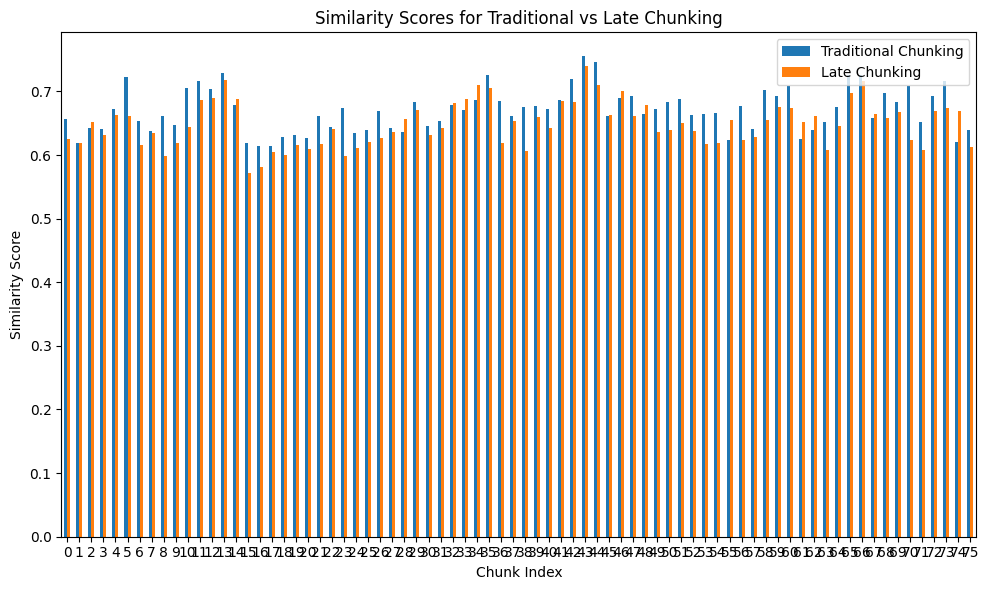

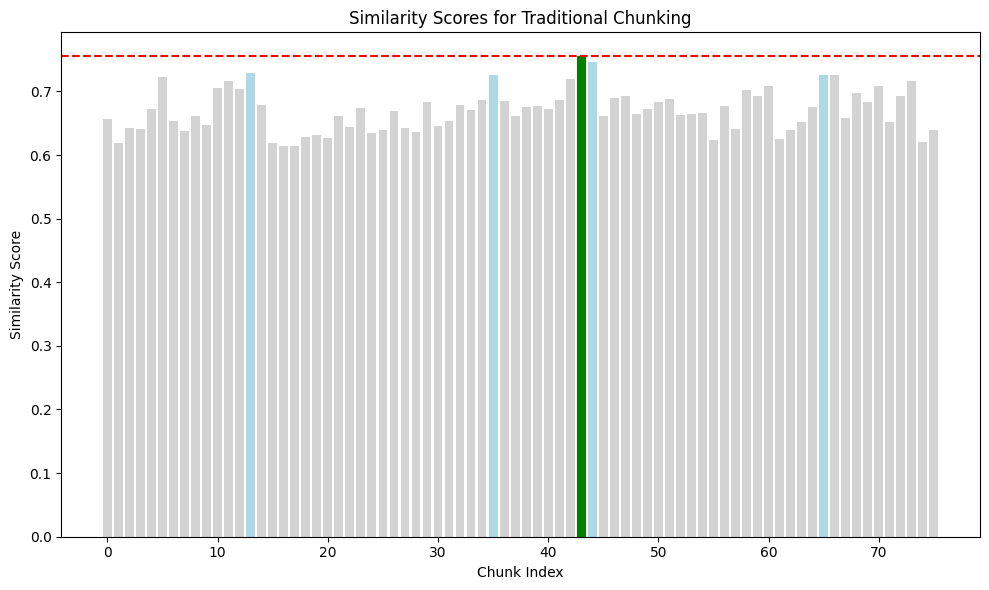

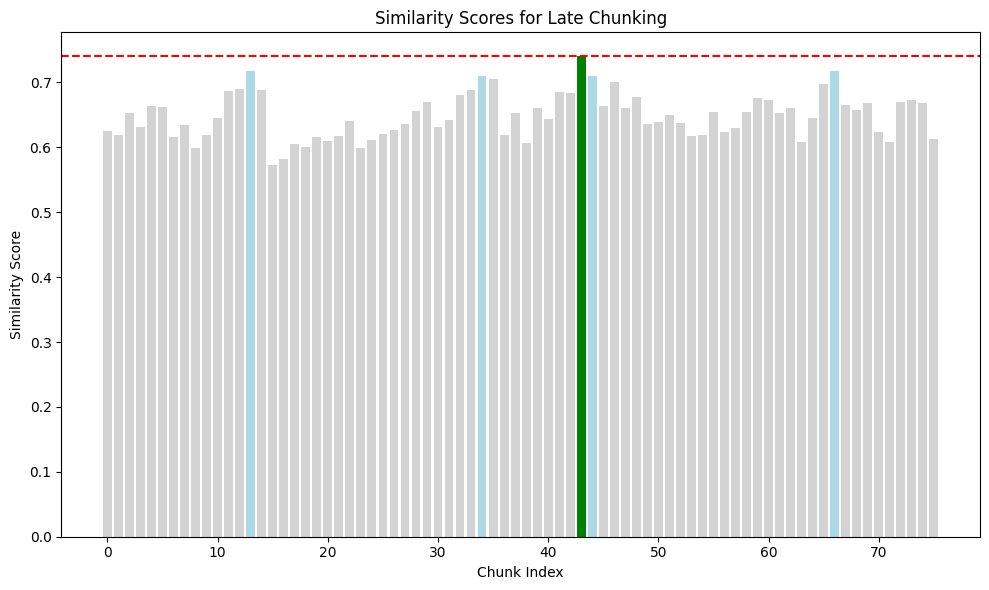

In [231]:
# visualize similarity_scores_traditional and similarity_scores_late_chunking
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd

plt.figure(figsize=(10, 6))

df = pd.DataFrame({
    "Traditional Chunking": similarity_scores_traditional,
    "Late Chunking": similarity_scores_late_chunking
})
df.plot(kind='bar', figsize=(10, 6))
plt.title("Similarity Scores for Traditional vs Late Chunking")
plt.xlabel("Chunk Index")
plt.ylabel("Similarity Score")
plt.xticks(rotation=0)
plt.legend(["Traditional Chunking", "Late Chunking"])
plt.tight_layout()
plt.show()

correct_chunks = [43]
# plot traditional chunking, highlight top 5 chunks in a different color
plt.figure(figsize=(10, 6))
plt.bar(range(len(similarity_scores_traditional)), similarity_scores_traditional, color='lightgray')
for i in top_5_traditional:
    plt.bar(i, similarity_scores_traditional[i], color='lightblue')
# plot correct chunks in a way that you can see whether they are in top 5 or not

for i in correct_chunks:
    color = 'green' if i in top_5_traditional else 'red'
    plt.bar(i, similarity_scores_traditional[i], color=color)

plt.axhline(y=similarity_scores_traditional[correct_chunks[0]], color='r', linestyle='--')

plt.title("Similarity Scores for Traditional Chunking")
plt.xlabel("Chunk Index")
plt.ylabel("Similarity Score")
plt.xticks(rotation=0)
# plt.legend(["Traditional Chunking", "Top 5 Chunks"])
plt.tight_layout()
plt.show()

# plot late chunking, highlight top 5 chunks in a different color
plt.figure(figsize=(10, 6))
plt.bar(range(len(similarity_scores_late_chunking)), similarity_scores_late_chunking, color='lightgray')

for i in top_5_late_chunking:
    plt.bar(i, similarity_scores_late_chunking[i], color='lightblue')
# plot correct chunks in a way that you can see whether they are in top 5 or not
for i in correct_chunks:
    color = 'green' if i in top_5_late_chunking else 'red'
    plt.bar(i, similarity_scores_late_chunking[i], color=color)

# draw a line at correct chunk[0]
plt.axhline(y=similarity_scores_late_chunking[correct_chunks[0]], color='r', linestyle='--')

plt.title("Similarity Scores for Late Chunking")
plt.xlabel("Chunk Index")
plt.ylabel("Similarity Score")
plt.xticks(rotation=0)
# plt.legend(["Traditional Chunking", "Top 5 Chunks"])
plt.tight_layout()
plt.show()
